# What are AI Agents?
**Agents** are systems built around a **LLM**, designed to extend the capabilities of the LLM by allowing it to use specialized tools. These tools are integrated through carefully crafted prompts and structured output parsing, enabling the LLM to address tasks it wouldn’t handle effectively on its own.

Such tools might include an image generator, a web search engine, or a calculator—functions that go beyond the LLM's inherent text-based processing capabilities.

## Transformers Agents

In this notebook, we are going to use the Transformer Agents library, which is an extension of our Transformers library that provides building blocks to build customized agents!

In [1]:
# install dependencies
!pip install "transformers[agents]" datasets langchain sentence-transformers faiss-cpu duckduckgo-search openai langchain-community --upgrade -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.

In [1]:
# call and connect with HF inference API
from huggingface_hub import notebook_login

notebook_login()

## 1. Multimodal + 🌐 Web-browsing assistant

In this notebook, we build a agent capable of capable of browsing the web and generating images.

This agent system is built around a large language model (LLM) as the core component. It processes user prompts and, based on the input, determines whether to utilize additional tools, such as web search, to gain a better understanding of the prompt and gather supplementary information. This enhanced context can then be used to call the image generator from the Hugging Face API when needed.


To build this agent, we need to prepare two key tools:
### 1.**Image Generation Tool**
   - This tool uses the **Hugging Face Inference API (Serverless)** to generate images via **Stable Diffusion**.
   - The tool is loaded directly from the Hugging Face Hub, providing seamless integration and functionality.

### 2.**Web Search Tool**
   - This is a **built-in tool** that allows the agent to search and retrieve information from the web.
   - It enables the agent to gather external knowledge to support its tasks.

By combining these tools, the agent can dynamically generate images and perform web searches to enhance its capabilities.

In [2]:
# import libraries
from transformers import load_tool, ReactCodeAgent, HfApiEngine

Imported components from the Transformers library:

  * **load_tool:** Used to load tools such as text-to-image generation or other task-specific utilities.

  * **ReactCodeAgent:** A customizable agent that integrates with an LLM and tools for complex problem-solving.

  * **HfApiEngine:**  Enables interaction with a Hugging Face API-based LLM.

### Initialize/load tools

In [3]:
# Import text-to-image tool from Hub
# m-ric/text-to-image model generates images based on textual descriptions.
image_generation_tool = load_tool("m-ric/text-to-image", cache=False) #cache=False ensures it fetches the latest tool updates directly from the Hub.

# Import search tool from LangChain
#This tool allows the agent to search for and retrieve information from the web.
from transformers.agents.search import DuckDuckGoSearchTool

search_tool = DuckDuckGoSearchTool()

You're loading a tool from the Hub from None. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TextToImageTool implements a different description in its configuration and class. Using the tool configuration description.



The **ReactCodeAgent** is initialized with loaded tools. This equips the agent to perform both image generation and web browsing tasks.

### ReAct
The ReactCodeAgent is an implementation of an agent framework that combines **Reasoning + Acting (ReAct)** principles with code execution capabilities. This type of agent operates by iteratively reasoning about the task, deciding on the necessary steps, and performing actions using external tools or executing code to achieve its goals.

1. **ReAct Framework:**
The agent leverages ReAct, a framework that enables it to generate reasoning traces (**thinking through a problem step by step**) and take actions (executing specific commands or utilizing tools) in response to user prompts.

2. **Code:** ReactCodeAgent can execute Python code or interact with code-related tools, allowing it to perform computational tasks, manipulate data, or even write and debug scripts as part of its workflow.


3. **Tool Integration:** It can integrate with tools like web search engines, calculators, APIs, or custom modules to extend its capabilities beyond language-based reasoning.


4. **Iterative Approach:** The agent evaluates intermediate results during execution and adapts its actions accordingly to ensure it converges on a solution effectively.

In [4]:
# Qwen2.5-72B-Instruct is a specific, a LLM fine-tuned for instruction-following tasks.
llm_engine = HfApiEngine("Qwen/Qwen2.5-72B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(tools=[image_generation_tool, search_tool], llm_engine=llm_engine)

Run Agent/inference

======== New task ========
Generate me a photo Tintin's airplane
=== Agent thoughts:
Thought: I need to use the `image_generator` tool to generate a photo of Tintin's airplane.
>>> Agent is executing the code below:
image = image_generator(prompt="A high-res, photorealistic image of Tintin's airplane")
final_answer(image)
====
Print outputs:

Last output from code snippet:
/tmp/tmpxxb9pv9u/903df3a6-ee40-48d5-8303-4db3c0e69849.png
Final answer:
/tmp/tmpxxb9pv9u/903df3a6-ee40-48d5-8303-4db3c0e69849.png


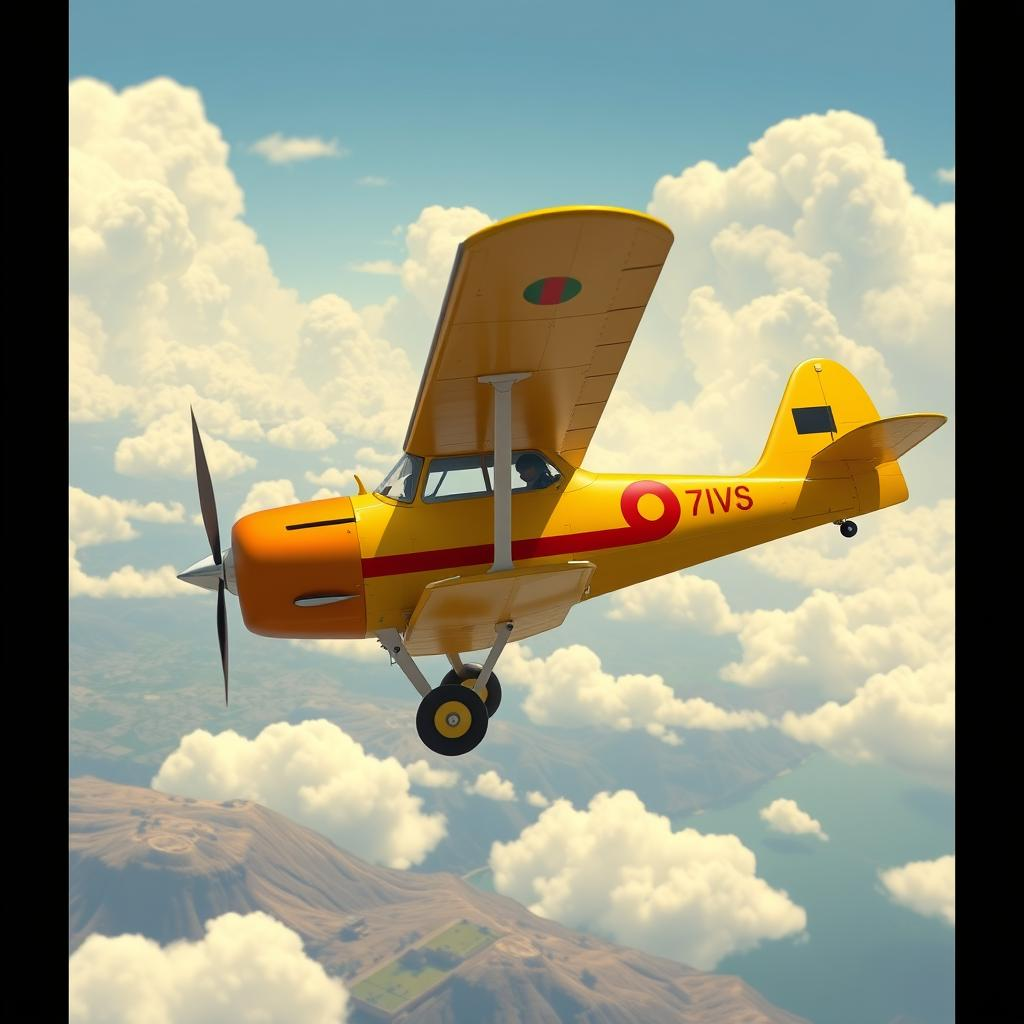

In [5]:
prompt= "Generate me a photo Tintin's airplane"

result = agent.run(
    prompt,
)
result

Plot and save result AgentImage

In [11]:
from PIL import Image
import torch
import numpy as np
import tempfile
import os
import uuid
import gradio as gr

# function to plot and save an AgentImage
def plot_and_save_agent_image(agent_image, save_path=None):
    # Convert AgentImage to a raw PIL Image
    pil_image = agent_image.to_raw()

    # Plot the image using PIL's show method
    pil_image.show()

    # If save_path is provided, save the image
    if save_path:
        pil_image.save(save_path)
        print(f"Image saved to {save_path}")
    else:
        print("No save path provided. Image not saved.")

# Plot and save the image
plot_and_save_agent_image(result, save_path="output_image2.png")

Image saved to output_image2.png


## APP to generate object history and future prediction

In [10]:
!pip install gradio pillow

In [15]:
def generate_prompts_for_object(object_name):
    prompts = {
        "past": f"Show an old version of a {object_name} from its early days.",
        "present": f"Show a modern {object_name} with its current design and technology.",
        "future": f"Show a futuristic version of a {object_name}, by predicting advanced features and futuristic design."
    }
    return prompts

# Function to generate the car industry history
def generate_object_history(object_name):
    images = []

    # Get prompts for the object
    prompts = generate_prompts_for_object(object_name)

    # Generate sequential images and display them
    for time_period, frame in prompts.items():
        print(f"Generating {time_period} frame: {frame}")
        result = agent.run(frame)  # The tool generates the image

        # Append the image to the list for GIF creation
        images.append(result.to_raw())  # Ensure we're using raw image for GIF

        # Save each image with the appropriate name (past, present, future)
        image_filename = f"{object_name}_{time_period}.png"
        plot_and_save_agent_image(result, save_path=image_filename)


    # Create GIF from images
    gif_path = f"{object_name}_evolution.gif"
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=1000,  # Duration in milliseconds for each frame
        loop=0          # Infinite loop
    )

    # Return images and GIF path
    return images, gif_path



In [ ]:
# Example usage:
object_name = "car"
images, gif_path = generate_object_history(object_name)

print(f"Generated images saved and GIF created: {gif_path}")

In [13]:
# Gradio interface
def create_gradio_interface():
    with gr.Blocks() as demo:
        gr.Markdown("# Object Evolution Generator")

        with gr.Row():
            with gr.Column():
                # Textbox for user to input an object name
                object_name_input = gr.Textbox(label="Enter an object name (e.g., car)", placeholder="Enter an object name", lines=1)

                # Button to trigger the generation of images and GIF
                generate_button = gr.Button("Generate Evolution")

                # Gradio Gallery component to display the images
                image_gallery = gr.Gallery(label="Generated Images", show_label=True, columns=[3], rows=[1])

                # Output for the generated GIF
                gif_output = gr.Image(label="Generated GIF", show_label=True)

        # Set the action when the button is clicked
        generate_button.click(fn=generate_object_history, inputs=[object_name_input], outputs=[image_gallery, gif_output])

    return demo

# Launch the Gradio app
demo = create_gradio_interface()
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8b16bb5aec378bf35e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
import gradio as gr
from PIL import Image

# Your existing generate_object_history function goes here

# Gradio interface
def create_gradio_interface():
    with gr.Blocks() as demo:
        gr.Markdown("# Object Evolution Generator")

        # Add a section for instructions
        gr.Markdown("""
        ## Welcome to the Object Evolution Generator!

        This app allows you to generate visualizations of how an object, like a bicycle or a car, may have evolved over time.
        It generates images of the object in the past, present, and future based on your input.

        ### How to use:
        - Enter the name of an object (e.g., "bicycle", "car", "phone").
        - Click "Generate Evolution" to generate the evolution of the object across three time periods: past, present, and future.
        - View the generated images and a GIF showing the evolution of the object.

        ### Example:
        Try entering an object name like "car" and see how it has evolved!
        """)

        with gr.Row():
            with gr.Column():
                # Textbox for user to input an object name
                object_name_input = gr.Textbox(label="Enter an object name (e.g., car)",
                                              placeholder="Enter an object name",
                                              lines=1)

                # Button to trigger the generation of images and GIF
                generate_button = gr.Button("Generate Evolution")

                # Gradio Gallery component to display the images
                image_gallery = gr.Gallery(label="Generated Images", show_label=True, columns=3, rows=1)

                # Output for the generated GIF
                gif_output = gr.Image(label="Generated GIF", show_label=True)

        # Set the action when the button is clicked
        generate_button.click(fn=generate_object_history, inputs=[object_name_input], outputs=[image_gallery, gif_output])

    return demo

# Launch the Gradio app (permanently)
demo = create_gradio_interface()

# To make it permanent and hosted, we can use Gradio's 'share' argument or host it on a server.
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6657d6c6c372fec114.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
